# Testando modelos

In [23]:
import pandas as pd
url_treino = 'https://raw.githubusercontent.com/alura-cursos/combina-classificadores/main/dados/train.csv'
url_teste = 'https://raw.githubusercontent.com/alura-cursos/combina-classificadores/main/dados/test.csv'

treino = pd.read_csv(url_treino)
teste = pd.read_csv(url_teste)
# treino.isnull().sum()

In [24]:
def prepara(df):
  df.drop(['Unnamed: 0', 'id'],axis=1,inplace=True)
  df.dropna(inplace=True)
  colunas_categoricas = ["Gender", "Customer Type", "Type of Travel", "Class"]
  df = pd.get_dummies(df, columns=colunas_categoricas)
  X = df.drop('satisfaction', axis=1)
  y = df['satisfaction']
  return X,y

In [25]:
X_treino, y_treino = prepara(treino)
X_teste, y_teste = prepara(teste)

X_treino.head()

y_treino.value_counts()

neutral or dissatisfied    58697
satisfied                  44897
Name: satisfaction, dtype: int64

## Arvore

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

modelo1 = DecisionTreeClassifier(random_state=42)

modelo1.fit(X_treino,y_treino)

validacao = cross_validate(modelo1, X_treino, y_treino, cv=5)

validacao['test_score'].mean()

0.9443500672495754

In [43]:
from sklearn.metrics import accuracy_score

y_pred = modelo1.predict(X_teste)

accuracy_score(y_teste,y_pred)

0.94612443517553

## Regressão Logística

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

modelo2 = LogisticRegression(random_state=42)

pipeline = Pipeline([
  ('scaler', StandardScaler()),  # Normalização dos dados
  ('model', modelo2)  # Modelo de Regressão Logística
])

pipeline.fit(X_treino, y_treino)

y_pred = pipeline.predict(X_teste)

accuracy_score(y_teste,y_pred)

0.8717027768122658

In [39]:
validacao = cross_validate(pipeline, X_treino, y_treino, cv=5)

validacao['test_score'].mean()

0.8749541859894492

# Votação

In [48]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

modelo3 = GaussianNB()

nome_modelos = ['Árvores', 'Logística','Naive Bayes']

In [105]:
pipelines = []
for modelo, nome in zip([modelo1,modelo2,modelo3],nome_modelos):

  pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalização dos dados
    ('model', modelo)
  ])

  validacao = cross_validate(pipeline, X_treino, y_treino, cv=5)
  pipelines.append(pipeline)

  print(validacao['test_score'].mean())
pipelines

0.9443983339909126
0.8749541859894492
0.8483406855152964


[Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', DecisionTreeClassifier(random_state=42))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', LogisticRegression(random_state=42))]),
 Pipeline(steps=[('scaler', StandardScaler()), ('model', GaussianNB())])]

In [52]:
# unindo os 3 modelos pra realizar a classificação
votacao = VotingClassifier(estimators=[(nome_modelos[0], pipelines[0]),
                                       (nome_modelos[1], pipelines[1]),
                                       (nome_modelos[2], pipelines[2])],
                           voting='hard')


validacao = cross_validate(votacao, X_treino, y_treino, cv=5)

validacao['test_score'].mean()


0.8917601803912731

In [54]:
votacao = VotingClassifier(estimators=[(nome_modelos[0], pipelines[0]),
                                       (nome_modelos[1], pipelines[1]),
                                       (nome_modelos[2], pipelines[2])],
                           voting='soft')


validacao = cross_validate(votacao, X_treino, y_treino, cv=5)

validacao['test_score'].mean()

0.9007375478071673

## Escolhendo os melhores para votação (VotingClassifier)

In [55]:
from sklearn.model_selection import GridSearchCV

parametros = {
    'voting':['hard','soft'],
    'weights':[(1,1,1),(2,1,1),(1,2,1),(1,1,2)]
}

gridsearch = GridSearchCV(votacao,parametros, n_jobs=-1)

gridsearch.fit(X_treino,y_treino)

GridSearchCV(estimator=VotingClassifier(estimators=[('Árvores',
                                                     Pipeline(steps=[('scaler',
                                                                      StandardScaler()),
                                                                     ('model',
                                                                      DecisionTreeClassifier(random_state=42))])),
                                                    ('Logística',
                                                     Pipeline(steps=[('scaler',
                                                                      StandardScaler()),
                                                                     ('model',
                                                                      LogisticRegression(random_state=42))])),
                                                    ('Naive Bayes',
                                                     Pipeline(steps=[('scaler',
                                                                      StandardScaler()),
                                                                     ('model',
                                                                      GaussianNB())]))],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'voting': ['hard', 'soft'],
                         'weights': [(1, 1, 1), (2, 1, 1), (1, 2, 1),
                                     (1, 1, 2)]})

In [56]:
gridsearch.best_params_

{'voting': 'soft', 'weights': (2, 1, 1)}

In [57]:
gridsearch.best_score_

0.9443983339909126

In [58]:
y_pred = gridsearch.predict(X_teste)

accuracy_score(y_teste,y_pred)

0.9462402966052601

# Bagging

In [60]:
from sklearn.ensemble import BaggingClassifier

# são criadas 10 arvores para 10 conjuntos de dados extraidos dos dos dados originais
bagging_classifier = BaggingClassifier(n_estimators=10, random_state=42)

bagging_classifier.fit(X_treino, y_treino)


BaggingClassifier(random_state=42)

In [67]:
modelo_base = pipelines[0]

parametros_grid = {
    'n_estimators': [10, 20, 30],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9],
}

In [68]:
# Encontrando os melhores parametros
bagging_grid = GridSearchCV(
    BaggingClassifier(),
    parametros_grid,
    cv=5,
    n_jobs=-1
)
# Treinar e ajustar o modelo
bagging_grid.fit(X_treino, y_treino)

GridSearchCV(cv=5, estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.7, 0.9],
                         'max_samples': [0.5, 0.7, 0.9],
                         'n_estimators': [10, 20, 30]})

In [69]:
melhores_parametros = bagging_grid.best_params_

# Criar e treinar o BaggingClassifier com os melhores parâmetros encontrados
bagging_classifier = BaggingClassifier(estimator=modelo_base, **melhores_parametros)

bagging_classifier.fit(X_treino, y_treino)


BaggingClassifier(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                            ('model',
                                             DecisionTreeClassifier(random_state=42))]),
                  max_features=0.9, max_samples=0.9, n_estimators=30)

In [70]:
y_pred = bagging_classifier.predict(X_teste)

accuracy_score(y_teste, y_pred)

0.9625767581971961

In [76]:
from sklearn.ensemble import ExtraTreesClassifier

parametros_grid = {
    'n_estimators': [10, 20, 30],
    'max_features': [0.5, 0.7, 0.9],
}

In [80]:
extratrees_grid = GridSearchCV(
    ExtraTreesClassifier(),
    parametros_grid,
    cv=5,
    n_jobs=-1
)

# Treinar e ajustar o modelo para extrair os melhores parametros
extratrees_grid.fit(X_treino, y_treino)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.7, 0.9],
                         'n_estimators': [10, 20, 30]})

In [81]:
melhores_parametros = extratrees_grid.best_params_

# Criar o ExtraTreesClassifier com os melhores parâmetros encontrados
extratrees_classifier = ExtraTreesClassifier(**melhores_parametros)

extratrees_classifier.fit(X_treino, y_treino)

ExtraTreesClassifier(max_features=0.9, n_estimators=30)

In [82]:
y_pred_tree = extratrees_classifier.predict(X_teste)

accuracy_score(y_teste, y_pred_tree)

0.9634264086818831

In [83]:
extratrees_grid.best_score_

0.9627391584907926

# Boosting

## AdaBoost

In [86]:
from sklearn.ensemble import AdaBoostClassifier

modelo = AdaBoostClassifier(n_estimators=50, learning_rate=1)

modelo.fit(X_treino, y_treino)

y_pred = modelo.predict(X_teste)

accuracy_score(y_teste, y_pred)

0.9263121306916927

In [87]:
param_grid = {
'n_estimators': [50,100,200],
'learning_rate': [0.1,0.01,0.001]
}

In [89]:
grid_search = GridSearchCV(
    AdaBoostClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_treino,y_treino)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [90]:
y_pred = grid_search.predict(X_teste)

accuracy_score(y_teste,y_pred)

grid_search.best_score_


0.9258161725228913

## CatBoost
instanciando o modelo já selecionando os melhores parametros

In [91]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.6 MB/s eta 0:00:00


In [92]:
from catboost import CatBoostClassifier

param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.1, 0.01, 0.001]
}

In [ ]:
grid_search = GridSearchCV(estimator=CatBoostClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_treino, y_treino)

In [96]:
y_pred_cat = grid_search.predict(X_teste)

accuracy_score(y_teste, y_pred_cat)

0.9641988182134168

# Stacking

In [97]:
from sklearn.ensemble import StackingClassifier

modelos_base = [
      (nome_modelos[0], pipelines[0]),
      (nome_modelos[1], pipelines[1]),
      (nome_modelos[2], pipelines[2])
]

modelos_base

[('Árvores',
  Pipeline(steps=[('scaler', StandardScaler()),
                  ('model', DecisionTreeClassifier(random_state=42))])),
 ('Logística',
  Pipeline(steps=[('scaler', StandardScaler()),
                  ('model', LogisticRegression(random_state=42))])),
 ('Naive Bayes',
  Pipeline(steps=[('scaler', StandardScaler()), ('model', GaussianNB())]))]

In [98]:
modelo_meta = LogisticRegression(random_state=42)

stacking_classifier = StackingClassifier(estimators=modelos_base, final_estimator=modelo_meta)

stacking_classifier.fit(X_treino, y_treino)


StackingClassifier(estimators=[('Árvores',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('model',
                                                 DecisionTreeClassifier(random_state=42))])),
                               ('Logística',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('model',
                                                 LogisticRegression(random_state=42))])),
                               ('Naive Bayes',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('model', GaussianNB())]))],
                   final_estimator=LogisticRegression(random_state=42))

In [99]:
y_pred = stacking_classifier.predict(X_teste)
accuracy_score(y_teste, y_pred)

0.9462402966052601

In [100]:
!pip install mlxtend

In [102]:
from mlxtend.classifier import StackingCVClassifier

#Melhores parâmetros do CatBoost e extraTrees
parametros_cat = grid_search.best_params_

parametros_trees = extratrees_grid.best_params_
print(parametros_trees, '\n', parametros_cat)

{'max_features': 0.9, 'n_estimators': 30} 
 {'depth': 8, 'iterations': 300, 'learning_rate': 0.1}


In [103]:
base_models = [
    CatBoostClassifier(**parametros_cat),
    ExtraTreesClassifier(n_estimators=100, random_state=42),
    pipelines[2]
]

In [107]:
stacking_cv_classifier = StackingCVClassifier(
                                            classifiers=base_models,
                                            meta_classifier=modelo_meta,
                                            cv=5
                                          )

mapeamento = {'neutral or dissatisfied': 0, 'satisfied': 1} # precisa ser 0 ou 1, string nao pode
y_treino = y_treino.replace(mapeamento)
y_teste = y_teste.replace(mapeamento)

In [108]:
stacking_cv_classifier.fit(X_treino, y_treino)

y_pred = stacking_cv_classifier.predict(X_teste)

stacking_cv_classifier.score(X_teste,y_teste)

0:	learn: 0.5405086	total: 32.7ms	remaining: 9.79s
1:	learn: 0.4459956	total: 70.4ms	remaining: 10.5s
2:	learn: 0.3444187	total: 164ms	remaining: 16.2s
3:	learn: 0.2967358	total: 209ms	remaining: 15.4s
4:	learn: 0.2482414	total: 275ms	remaining: 16.2s
5:	learn: 0.2204898	total: 355ms	remaining: 17.4s
6:	learn: 0.2011269	total: 428ms	remaining: 17.9s
7:	learn: 0.1854966	total: 466ms	remaining: 17s
8:	learn: 0.1768774	total: 509ms	remaining: 16.5s
9:	learn: 0.1689946	total: 567ms	remaining: 16.4s
10:	learn: 0.1632080	total: 647ms	remaining: 17s
11:	learn: 0.1561421	total: 723ms	remaining: 17.4s
12:	learn: 0.1504509	total: 809ms	remaining: 17.9s
13:	learn: 0.1466042	total: 891ms	remaining: 18.2s
14:	learn: 0.1436784	total: 970ms	remaining: 18.4s
15:	learn: 0.1411843	total: 1.05s	remaining: 18.7s
16:	learn: 0.1370337	total: 1.14s	remaining: 18.9s
17:	learn: 0.1351622	total: 1.19s	remaining: 18.7s
18:	learn: 0.1313862	total: 1.26s	remaining: 18.7s
19:	learn: 0.1278930	total: 1.34s	remaining

0.9628084810566563

# Analisando resultados

In [109]:
validacao = cross_validate(stacking_cv_classifier, X_treino, y_treino, cv=5, n_jobs=-1)
validacao['test_score'].mean()

array([0.96172595, 0.96375308, 0.96090545, 0.96515276, 0.9643788 ])

In [113]:
from mlxtend.evaluate import scoring

error = scoring(y_target=y_teste, y_predicted=y_pred, metric='error')
precision = scoring(y_target=y_teste, y_predicted=y_pred, metric='precision')
recall = scoring(y_target=y_teste, y_predicted=y_pred, metric='recall')
f1 = scoring(y_target=y_teste, y_predicted=y_pred, metric='f1')

print(f"Error: {error}, Precision: {precision}, Recall: {recall}, F1: {f1}")


Error: 0.037191518943343715, Precision: 0.9668761220825853, Recall: 0.9477342718873735, F1: 0.9572095089980004


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

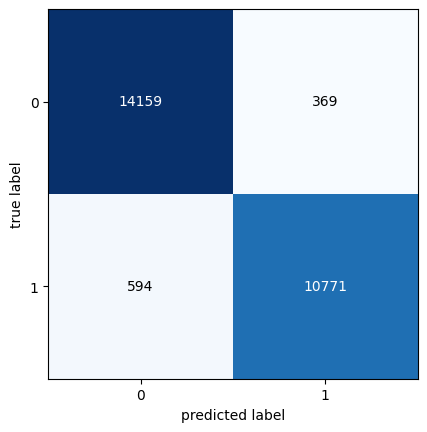

In [111]:
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

matriz_confusao = confusion_matrix(y_teste, y_pred)

plot_confusion_matrix(conf_mat=matriz_confusao)

# exportando e testando o modelo

In [112]:
import joblib

joblib.dump(stacking_cv_classifier, 'modelo_treinado.pkl')

['modelo_treinado.pkl']

In [114]:
modelo_carregado = joblib.load('modelo_treinado.pkl')

previsao = modelo_carregado.predict([X_teste.iloc[2]])
previsao

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0])